## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.   

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
# Import libraries that will be used in this project
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# We are setting the seed to assure we get the same answers on quizzes as we set up
random.seed(42)

`1.` Understanding the Data:

Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Load ab_data.csv into dataframe
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [3]:
print('The number of rows in the dataset:',len(df))

The number of rows in the dataset: 294478


c. The number of unique users in the dataset.

In [4]:
print('The number of unique users in the dataset:',df.user_id.nunique())

The number of unique users in the dataset: 290584


d. The proportion of users converted.

In [5]:
print('The proportion of users converted:',df.converted.mean())

The proportion of users converted: 0.119659193556


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
print('The number of times the new_page and treatment do not match:',len(df.query("(landing_page=='new_page' & group=='control')|(landing_page=='old_page' & group=='treatment')")))

The number of times the new_page and treatment do not match: 3893


f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No rows has missing values.

`2.` Deal with Messy Data:

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Create a new dataset that only contains rows where **treatment** matches with **new_page**.  Store the new dataframe in **df2**.

In [8]:
# Store matches rows in dataframe df2 
df2=df.query("(landing_page=='new_page' & group=='treatment')|(landing_page=='old_page' & group=='control')")

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Remove duplicates:

a. How many unique **user_id**s are in **df2**?

In [10]:
print('The number of unique user_ids:',df2.user_id.nunique())

The number of unique user_ids: 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()==True].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [13]:
# Drop the duplicated row and keep the first row of the duplicates
df2.drop_duplicates(subset='user_id',keep='first',inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


`4.` Probability:

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
p_convert=df2.converted.mean()
print('The probability of an individual converting:',p_convert)

The probability of an individual converting: 0.119597087245


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control=df2[df2.group=='control'].converted.mean()
print('The probability of a control group individual converting:',p_control)

The probability of a control group individual converting: 0.1203863045


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treat=df2[df2.group=='treatment'].converted.mean()
print('The probability of a treatment group individual converting:',p_treat)

The probability of a treatment group individual converting: 0.118808065515


d. What is the probability that an individual received the new page?

In [17]:
print('The probability of an individual received the new page:',len(df2[df2.landing_page=='new_page'])/len(df2))

The probability of an individual received the new page: 0.5000619442226688


e. Explain below whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Since the convertion rate for treatment group is lower than control group, we cannot conclude that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, based on all the data provided, we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. The null and alternative hypotheses are stated below. **$p_{old}$** and **$p_{new}$**, are the converted rates for the old and new pages.

$$H_0: p_{old} - p_{new} \geq 0$$
$$H_1: p_{old} - p_{new} < 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
print('The conversion rate for  𝑝𝑛𝑒𝑤  under the null:',df2.converted.mean())

The conversion rate for  𝑝𝑛𝑒𝑤  under the null: 0.119597087245


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
print('The conversion rate for  𝑝𝑜𝑙𝑑  under the null:',df2.converted.mean())

The conversion rate for  𝑝𝑜𝑙𝑑  under the null: 0.119597087245


c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
df_new=df2[df2.group=='treatment']
nnew=len(df_new)
print('The number of individuals in the treatment group:',nnew)

The number of individuals in the treatment group: 145310


d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
df_old=df2[df2.group=='control']
nold=len(df_old)
print('The number of individuals in the control group:',nold)

The number of individuals in the control group: 145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# Bootstrap samples from the treatment group
new_page_converted=df_new["converted"].sample(nnew,replace=True)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# Bootstrap samples from the control group
old_page_converted=df_old["converted"].sample(nold,replace=True)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
pnew_pold=new_page_converted.mean()-old_page_converted.mean()
print('𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 =',pnew_pold)

𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 = -0.00456556585419


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
# Initiate empty arrays
p_new, p_old, p_diffs = [],[],[]
# Iterate 10000 times on the simulation process
for _ in range(10000):
    pnew = df_new["converted"].sample(nnew,replace=True).mean()
    pold = df_new["converted"].sample(nold,replace=True).mean()
    # append the info 
    p_new.append(pnew) 
    p_old.append(pold) 
    p_diffs.append(pnew-pold) 

i. Plot a histogram of the **p_diffs**.  

Text(0,0.5,'Number of Users')

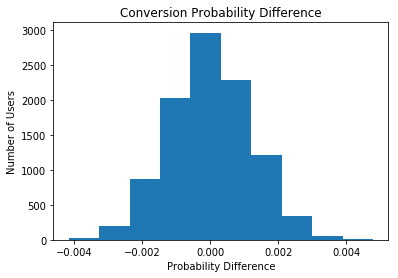

In [26]:
plt.hist(p_diffs)
plt.title('Conversion Probability Difference')
plt.xlabel('Probability Difference')
plt.ylabel('Number of Users')

The plot is a normal distribution, this is expected.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
p_diffs_actual=p_treat-p_control
print('The proportion of the simulation are greater than the actual difference observed:','{0:0.3f}'.format(np.mean(p_diffs>p_diffs_actual)))

The proportion of the simulation are greater than the actual difference observed: 0.906


k. What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**It's called p-value. The probability of the observed change in average conversion rate occurring or an average change even more in favor of an increase in conversion rate given there was actually no change in conversion rate is 90.7%. We cannot say that there is a difference between the new and old pages.**

l. We could also use a built-in to achieve similar results.  Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df_old.converted.sum()
convert_new = df_new.converted.sum()
n_old = len(df_old)
n_new = len(df_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value. 

In [29]:
stat, pval=sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')
print('z_score:','{0:0.3f}'.format(stat))
print('p_value:','{0:0.3f}'.format(pval))

z_score: 1.311
p_value: 0.905


n. What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value means there is 90.5% of chance that old page has higher conversion rate than the new page. It's higher than 5%, so we cannot say that the new pages have increasing conversion rate than the old pages. This result agrees with the findings in parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We should perform Logistic Regresion**

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
# Add a column for intercept
df2['intercept'] = 1
# Create a dummy variable column for which page each user received
# 1-treatment; 0-control
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate the regression model on the two columns created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [31]:
# Run the logistic regression model on ab_page
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of the model below.

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        02:20:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value in **Part II**?<br><br>

**The p-value of ab_page is 0.19. The null and alternative hypotheses associated with the regression model is wether or not the new page is a significant factor in prediciting the conversion, whereas the null and alternative hypotheses in Part II is wether or not the new page has higher conversion rate than the old page. The difference in the hypotheses makes the results different.**

f. Now, we are considering other things that might influence whether or not an individual converts.  

**Advantage of adding other factors into the regression model: it can significantly increase R squre statistics of the model, making the model more reliable.**

**Disadvantage: the factos added may have multicollinearity, which distorts the regression statistics and leads to incorrect conclusions**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.


In [33]:
# Load countries.csv into dataframe c
c=pd.read_csv("countries.csv")
# Left join df2 with c to include country code column into the new dataframe df3
df3=pd.merge(df2,c,how="left",on='user_id')
# Create dummy variables for each country in the country column
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3 = df3.drop('UK', axis=1)
# Run the new logistic regression model adding the country variables
log_mod2 = sm.Logit(df3['converted'], df3[['intercept','ab_page','CA','US']])
results2 = log_mod2.fit()
# Print the statistical output of the new regression model
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        02:20:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

**Since the p-values for the country varibles are larger than 0.05, we cannot say that country had an impact on conversion.**

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [34]:
# Add columns to capture interaction between page and country
df3['page_CA']=df3['ab_page']*df3['CA']
df3['page_US']=df3['ab_page']*df3['US']
# Run the new logistic regression model adding the interaction variables
log_mod3 = sm.Logit(df3['converted'], df3[['intercept','ab_page','CA','US','page_CA','page_US']])
results3 = log_mod3.fit()
# Print the statistical output of the new regression model
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        02:20:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
page_CA       -0.0783      0.057     -1.378      0.168      -0.190       0.033
page_US       -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

**Since the p-values for the interaction varibles are larger than 0.05, we cannot say that the interaction between page and country had an impact on conversion.**

<a id='conclusions'></a>
## Finishing Up

In [35]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0